In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import time

from sklearn.linear_model import LinearRegression, LogisticRegression
import pysal as ps
import spacv
from spacv.grid_builder import *
from scipy.spatial.distance import pdist, squareform
import spreg
import skgstat as skg

np.set_printoptions(precision=7)
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
np.printoptions(suppress=True)

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2dev-CAPI-1.11.2 0) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
def geometry_to_2d(geometry):
    return np.array(list(map(lambda x : (x.x, x.y), geometry)))

In [3]:
n = 1000000

x = np.random.randint(0, 3000, n)
y = np.random.randint(0, 3000, n)

gdf = gpd.GeoDataFrame({'geometry': gpd.points_from_xy(x,y)})
data = np.random.random((n,5))

y, gdf['V2'], gdf['V3'], gdf['V4'], gdf['V5'] = data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]
X = gdf[['V2', 'V3', 'V4', 'V5']].values

XYs = gdf['geometry']

In [33]:
df = gpd.read_file('/opt/conda/lib/python3.7/site-packages/libpysal/examples/baltim/baltim.shp')

XYs = df['geometry']
X = df[['NROOM', 'DWELL', 'NBATH', 'PRICE', 'LOTSZ', 'SQFT']]
y = df['PRICE']

# Speed

In [31]:
cv = spacv.HBLOCK(10,5, method='unique', buffer_radius=500)

In [32]:
%%timeit
for tr,te in cv.split(XYs):
    pass

31.6 s ± 1.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [64]:
cv = spacv.SKCV(folds=10)

In [65]:
%%timeit
for tr,te in cv.split(XYs):
    pass

1min 53s ± 3.06 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
cv = spacv.SKCV(folds=10, buffer_radius=500)

In [67]:
%%timeit
for tr,te in cv.split(XYs):
    pass

1min 56s ± 3.54 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
cv = spacv.RepeatSKCV(folds=10, n_repeats=2)

In [69]:
%%timeit
for tr,te in cv.split(XYs):
    pass

3min 40s ± 1.79 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [70]:
cv = spacv.RepeatSKCV(folds=10, n_repeats=2, buffer_radius=500)

In [71]:
%%timeit
for tr,te in cv.split(XYs):
    pass

3min 45s ± 3.98 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
sample_XYs = XYs.sample(100000)

In [10]:
cv = spacv.SKCV(folds= len(sample_XYs))

In [12]:
%%timeit -r 1 -n 1
for tr,te in cv.split(sample_XYs):
    pass

8min 6s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Sklearn integration

In [13]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC

In [14]:
skcv = spacv.SKCV().split(XYs)

In [ ]:
svc = SVC()

cross_val_score(svc, X, y, cv = skcv)

In [23]:
skcv = spacv.SKCV().split(XYs)

In [18]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

In [19]:
clf = GridSearchCV(estimator=svc, 
                   param_grid=parameters, 
                   cv = skcv # An iterable yielding (train, test) splits as arrays of indices
                  )

In [21]:
clf.fit(X, y)

GridSearchCV(cv=<generator object BaseSpatialCV.split at 0x7f94e74ecb88>,
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [22]:
clf.best_params_

{'C': 10, 'kernel': 'rbf'}

# Visualisaton

In [ ]:
from spacv.visualisation import *

# Ad-hoc grid/fold construction

In [41]:
df = gpd.read_file('/opt/conda/lib/python3.7/site-packages/libpysal/examples/baltim/baltim.shp')

XYs = df['geometry']
X = df[['NROOM', 'DWELL', 'NBATH', 'PRICE', 'LOTSZ', 'SQFT']]
y = df['PATIO']

model = LinearRegression(fit_intercept=True)

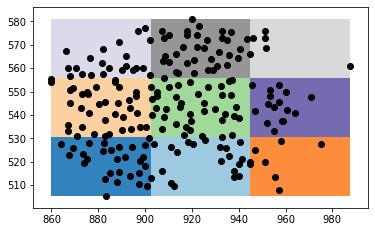

In [44]:
f, ax = plt.subplots(1)
construct_blocks(XYs, tiles_x=3, tiles_y=3, method='unique').plot(column='grid_id', cmap='tab20c',ax=ax)
XYs.plot(ax=ax, color='black')
plt.show()

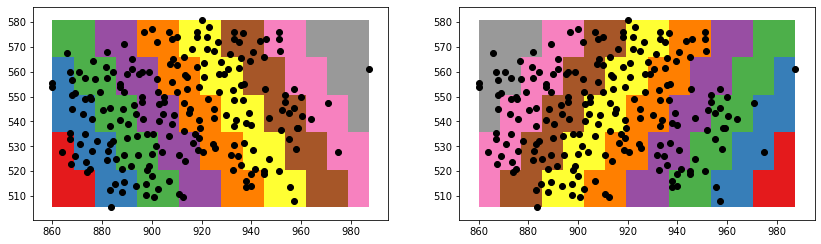

In [50]:
f, ax = plt.subplots(1,2, figsize=(14,12))

construct_blocks(XYs, method='systematic', tiles_x=15, tiles_y=5, direction='anti').plot(column='grid_id', cmap='Set1', ax=ax[0])
construct_blocks(XYs, method='systematic', tiles_x=15, tiles_y=5, direction='diagonal').plot(column='grid_id', cmap='Set1', ax=ax[1])

XYs.plot(ax=ax[0], color='black')
XYs.plot(ax=ax[1], color='black');

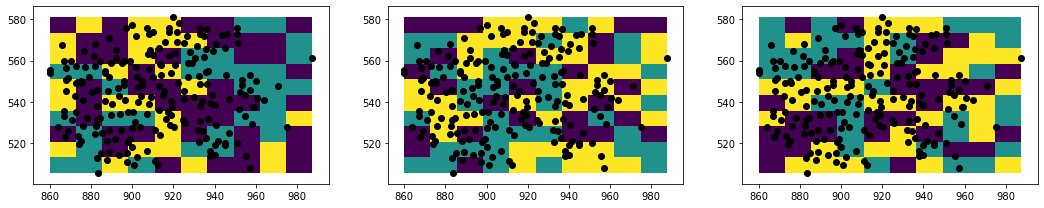

In [58]:
f, ax = plt.subplots(1,3, figsize=(18,20))
construct_blocks(df, method='random', tiles_x=10, tiles_y=10, n_groups=3).plot(column='grid_id', ax=ax[0])
construct_blocks(df, method='random', tiles_x=10, tiles_y=10, n_groups=3).plot(column='grid_id', ax=ax[1])
construct_blocks(df, method='random', tiles_x=10, tiles_y=10, n_groups=3).plot(column='grid_id', ax=ax[2])
XYs.plot(ax=ax[0], color='black')
XYs.plot(ax=ax[1], color='black')
XYs.plot(ax=ax[2], color='black');

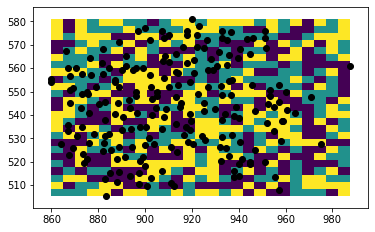

In [51]:
f, ax = plt.subplots(1)
construct_blocks(df, method='optimized_random', tiles_x=25, tiles_y=25, n_groups=3).plot(column='grid_id', ax=ax)
df.plot(ax=ax, color='black');

# Future

* User specified geographies for folds.

In [347]:
envelope = XYs.unary_union.envelope

In [348]:
env = gpd.GeoDataFrame({'geometry': [envelope]}).scale(xfact=1.25, yfact=1.25)

In [359]:
xmin,ymin,xmax,ymax = env.total_bounds # lat-long of 2 corners

# xmin,ymin,xmax,ymax = XYs.total_bounds # lat-long of 2 corners


EW = euclidean((xmin,ymin),(xmax,ymin))
# North-South extent of Toronto = 30519 metres
NS = euclidean((xmin,ymin),(xmin,ymax))
# diamter of each hexagon in the grid = 900 metres
d = 50
# horizontal width of hexagon = w = d* sin(60)
w = d*np.sin(np.pi/3)
# Approximate number of hexagons per row = EW/w 
n_cols = int(EW/w)+1
# Approximate number of hexagons per column = NS/d
n_rows = int(NS/d)+ 1

In [360]:
n_cols = 5
n_rows = 3

In [361]:
w = (xmax-xmin)/n_cols # width of hexagon
d = w/np.sin(np.pi/3) #diameter of hexagon

In [362]:
array_of_hexes = []
for rows in range(0,n_rows):
    hcoord = np.arange(xmin,xmax,w) + (rows%2)*w/2
    vcoord = [ymax- rows*d*0.75]*n_cols
    for x, y in zip(hcoord, vcoord):#, colors):
        hexes = RegularPolygon((x, y), numVertices=6, radius=d/2, alpha=0.2, edgecolor='k')
        verts = hexes.get_path().vertices
        trans = hexes.get_patch_transform()
        points = trans.transform(verts)
        array_of_hexes.append(Polygon(points))
geo = gpd.GeoDataFrame({'geometry':array_of_hexes})

<AxesSubplot:>

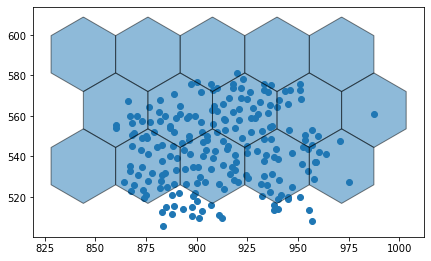

In [364]:
f, ax = plt.subplots(1, figsize=(7,7))

XYs.plot(ax=ax)
geo.plot(ax=ax, alpha=.5, edgecolor='black')

<AxesSubplot:>

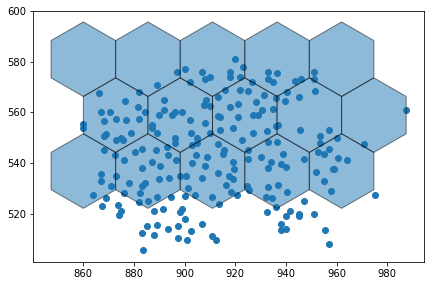

In [358]:
f, ax = plt.subplots(1, figsize=(7,7))

XYs.plot(ax=ax)
geo.plot(ax=ax, alpha=.5, edgecolor='black')

In [228]:

array_of_hexes = []
for rows in range(0,n_rows):
    hcoord = np.arange(xmin,xmax,w) + (rows%2)*w/2
    vcoord = [ymax- rows*d*0.75]*n_cols
    for x, y in zip(hcoord, vcoord):#, colors):
        hexes = RegularPolygon((x, y), numVertices=6, radius=d/2, alpha=0.2, edgecolor='k')
        verts = hexes.get_path().vertices
        trans = hexes.get_patch_transform()
        points = trans.transform(verts)
        array_of_hexes.append(Polygon(points))
geo = gpd.GeoDataFrame({'geometry':array_of_hexes})


In [320]:
n_rows = 5
n_cols = 5

xmin, ymin, xmax, ymax = XYs.total_bounds

w = (xmax-xmin)/n_cols # width of hexagon
d = w/np.sin(np.pi/3) #diameter of hexagon

array_of_hexes = []

for rows in range(0, n_rows):
    hcoord = np.arange(xmin, xmax, w) + (rows % 2) * w/2
    vcoord = [ymax - rows * d * 0.75] * n_cols
    
    for x, y in zip(hcoord, vcoord):#, colors):
        hexes = RegularPolygon((x, y), numVertices=6, radius=d/2, alpha=0.2, edgecolor='k')
        verts = hexes.get_path().vertices
        trans = hexes.get_patch_transform()
        points = trans.transform(verts)
        array_of_hexes.append(Polygon(points))

geo = gpd.GeoDataFrame({'geometry':array_of_hexes})

<AxesSubplot:>

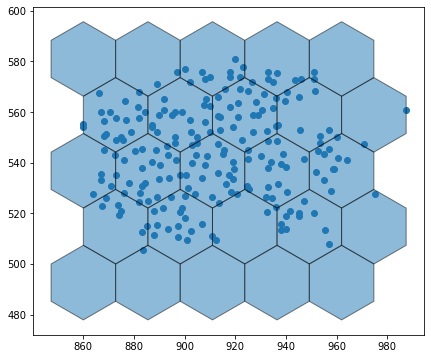

In [321]:
f, ax = plt.subplots(1, figsize=(7,7))

XYs.plot(ax=ax)
geo.plot(ax=ax, alpha=.5, edgecolor='black')

In [37]:
Nhoods = gpd.read_file('/home/jovyan/host/Neighbourhoods.geojson')

In [38]:
Nhoods = gpd.GeoDataFrame(Nhoods,geometry='geometry',crs={'init':'epsg:4326'})

In [42]:
Nhoods['FIELD_4'] = 1

In [43]:
TO_boundary = Nhoods.dissolve(by='FIELD_4')
TO_boundary = TO_boundary[['geometry']]

In [45]:
xmin,ymin,xmax,ymax = Nhoods.total_bounds # lat-long of 2 corners
#East-West extent of Toronto = 42193 metres
EW = haversine((xmin,ymin),(xmax,ymin))
# North-South extent of Toronto = 30519 metres
NS = haversine((xmin,ymin),(xmin,ymax))
# diamter of each hexagon in the grid = 900 metres
d = 900
# horizontal width of hexagon = w = d* sin(60)
w = d*np.sin(np.pi/3)
# Approximate number of hexagons per row = EW/w 
n_cols = int(EW/w)+1
# Approximate number of hexagons per column = NS/d
n_rows = int(NS/d)+ 1

In [56]:
w = (xmax-xmin)/n_cols # width of hexagon
d = w/np.sin(np.pi/3) #diameter of hexagon

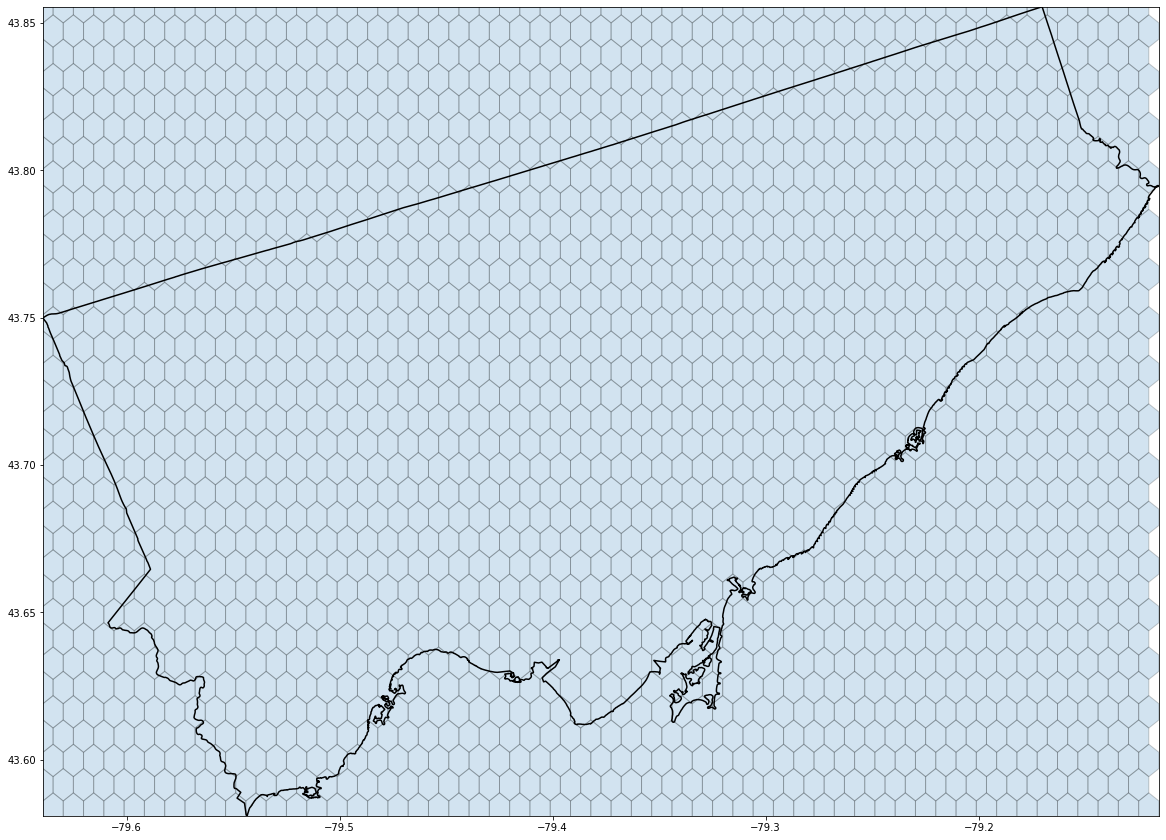

In [59]:
ax = TO_boundary.boundary.plot(edgecolor='black',figsize=(20,60))

array_of_hexes = []
for rows in range(0,n_rows):
    hcoord = np.arange(xmin,xmax,w) + (rows%2)*w/2
    vcoord = [ymax- rows*d*0.75]*n_cols
    for x, y in zip(hcoord, vcoord):#, colors):
        hexes = RegularPolygon((x, y), numVertices=6, radius=d/2, alpha=0.2, edgecolor='k')
        verts = hexes.get_path().vertices
        trans = hexes.get_patch_transform()
        points = trans.transform(verts)
        array_of_hexes.append(Polygon(points))
        ax.add_patch(hexes)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()

In [161]:
def variogram_at_lag(XYs, y, lags, bw):
    
    XYs = geometry_to_2d(XYs)
    y = np.asarray(y)
    paired_distances = pdist(XYs)
    pd_m = squareform(paired_distances)
    semivariances = []
    
    for lag in lags:
        lower = pd_m >= lag-bw
        upper = pd_m <= lag+bw
        mask = np.logical_and(lower, upper)

        semivariances.append(compute_semivariance(y, mask, lag, bw))
        
    return np.c_[semivariances, lags]

def compute_semivariance(y, mask, lag, bw):
    semis, counts = [], []
    for i in range( len(y) ):
        yi = np.array([y[i]])
        mask_i = mask[i,:]
        mask_i[:i] = False
        yj = y[mask_i]
        ss = (yi - yj)**2 
    
        filter_empty =  ss > 0. 
        if len(ss[filter_empty]) > 0:
            counts.append( len(ss[filter_empty]))
            semis.append(ss[filter_empty])
    
    semivariance = np.sum( np.concatenate(semis)) / (2.0 * sum(counts) )
    
    return semivariance

In [162]:
lags = np.arange(100, 1000, 100)

In [181]:
sem = []
for x in X.T:
    semis = variogram_at_lag(XYs, x, lags, bw)
    
    sem.append(semis)

In [188]:
from scipy.optimize import curve_fit


In [124]:
y_pos = np.arange(len(h))


AttributeError: module 'matplotlib.pyplot' has no attribute 'xaxislabel'

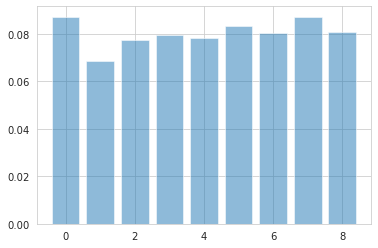

In [135]:
plt.bar(y_pos, sv, align='center', alpha=0.5)
plt.xaxislabel(h)

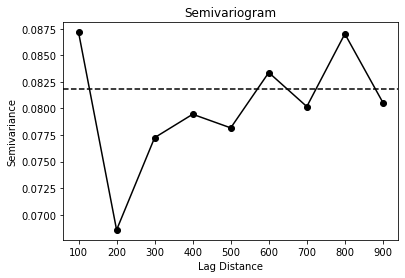

In [117]:
    
fig, ax = plt.subplots()
ax.plot(h, sv, 'ko-')
ax.set_ylabel('Semivariance')
ax.set_xlabel('Lag Distance')
ax.set_title('Semivariogram')
# ax.text(tol * 3, sill * 1.025, str(np.round(sill, decimals=3)))
ax.axhline(sill, ls='--', color='k')
plt.show()

In [78]:
def variogram_at_lag(pd_m, y, lag, bw):
    ssvs = []
    for i in range(n):
        for j in range(i+1, n):
            if ( pd_m[i,j] >= lag-bw) and ( pd_m[i,j] <= lag+bw):
                ssvs.append( (y[i] - y[j])**2 )
    semivariance = np.sum(ssvs) / (2.0 * len(ssvs) )
    
    return semivariance

def plot_variogram(XYs, y, lags, bw, **kwargs):
    
    XYs = geometry_to_2d(XYs.geometry)
    y = np.asarray(y)

    paired_distances = pdist(XYs)
    pd_m = squareform(paired_distances)
    n = pd_m.shape[0]
    
    semivariances = [variogram_at_lag(pd_m, y, lag, bw) for lag in lags] 
    
    return semivariances

In [ ]:
%%timeit -n 1 -r 1
plot_variogram(XYs, y, lags, bw)